# Db2 Data Management Console Overview

This Jupyter Notebook contains examples of how to use the Open APIs and composable interface that is available in the Db2 Data Management Console. Everything in the User Interface is also available through an open and fully documented RESTful Services API. You can find the full documentation in the Help included with the Db2 Data Management Console.

You can also embed elements of the full user interface into an IFrame by constructing the appropriate URL. 

### First we will import a few helper classes

In [1]:
# Import the class libraries 
import requests
import ssl
import json
from pprint import pprint
from requests import Response
import pandas as pd
import time
from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)
from IPython.display import IFrame
from IPython.display import display, HTML
from pandas.io.json import json_normalize

### The Db2 Class
Next we will create a Db2 helper class that will encapsulate the Rest API calls that we can use to directly access the Db2 Data Management Console service without having to use the user interface. 

To access the service we need to first authenticate with the service and create a reusable token that we can use for each call to the service. This ensures that we don't have to provide a userID and password each time we run a command. The token makes sure this is secure. 

Each request is constructed of several parts. First, the URL and the API identify how to connect to the service. Second the REST service request that identifies the request and the options. For example '/metrics/applications/connections/current/list'. And finally some complex requests also include a JSON payload. For example running SQL includes a JSON object that identifies the script, statement delimiters, the maximum number of rows in the results set as well as what do if a statement fails.

In [2]:
# Run the Db2 Class library
# Used to construct and reuse an Autentication Key
# Used to construct RESTAPI URLs and JSON payloads
class Db2():
    
    def __init__(self, url, verify = False, proxies=None, ):
        self.url = url
        self.proxies = proxies
        self.verify = verify

    def authenticate(self, userid, password, profile=""):
        credentials = {'userid':userid, 'password':password}
        r = requests.post(self.url+'/auth/tokens', verify=self.verify, json=credentials, proxies=self.proxies)
        if (r.status_code == 200):
            bearerToken = r.json()['token']
            if profile == "":
                self.headers = {'Authorization': 'Bearer'+ ' '+bearerToken}
            else:
                self.headers = {'Authorization': 'Bearer'+ ' '+bearerToken, 'X-DB-Profile': profile}
        else:
            print ('Unable to authenticate, no bearer token obtained')
        
    def printResponse(self, r, code):
        if (r.status_code == code):
            pprint(r.json())
        else:
            print (r.status_code)
            print (r.content)
    
    def getRequest(self, api, json=None):
        return requests.get(self.url+api, verify = self.verify, headers=self.headers, proxies = self.proxies, json=json)

    def postRequest(self, api, json=None):
        return requests.post(self.url+api, verify = self.verify, headers=self.headers, proxies = self.proxies, json=json) 
        
    def getStatusCode(self, response):
        return (response.status_code)

    def getJSON(self, response):
        return (response.json())
    
    def getSchemas(self):
        return self.getRequest('/schemas')
    
    def runSQL(self, script, limit=10, separator=';', stopOnError=False):
        sqlJob = {'commands': script, 'limit':limit, 'separator':separator, 'stop_on_error':str(stopOnError)}
        return self.postRequest('/sql_jobs',sqlJob)
        
    def getSQLJobResult(self, jobid):
        return self.getRequest('/sql_jobs/'+jobid)
    
    def getCurrentApplicationsConnections(self, includeSystem='true'):
        return self.getRequest('/metrics/applications/connections/current/list?&include_sys='+str(includeSystem))
    
    def getInflightCount(self, startTime, endTime):
        return self.getRequest('/metrics/statements/inflight_executions/current/list?start='+str(startTime)+'&end='+str(endTime));
       
    def getInflightCurrentList(self, includeSystem='true'):
        return self.getRequest('/metrics/statements/inflight_executions/current/list?'+'&include_sys='+str(includeSystem));
    
    def getIndividualStatementExecution(self, startTime, endTime, limit=100, includeSystem='false'):
        return self.getRequest('/metrics/statements/evmon_activity?start='+str(startTime)+'&end='+str(endTime)+'&include_sys='+str(includeSystem)+'&offset=0&limit='+str(limit))

    def getFiles(self, path):
        return self.getRequest('/home'+path)
    
    def getUsers(self):
        return self.getRequest('/users')
    
    def getTablesMetrics(self, startTime, endTime, includeSystem='false'):
        return self.getRequest('/metrics/tables?start='+str(startTime)+'&end='+str(endTime)+'&include_sys='+str(includeSystem));

    def getAverageResponseTime(self, startTime, endTime):
        return self.getRequest('/metrics/average_response_time?start='+str(startTime)+'&end='+str(endTime));    
    
    def getUnitsOfWork(self, startTime, endTime):
        return self.getRequest('/applications/uow?start='+str(startTime)+'&end='+str(endTime));    
    
    def getSchemaSize(self, startTime, endTime, tabSchema):
        return self.getRequest('/metrics/storage/schemas/'+tabSchema+'/timeseries?start='+str(startTime)+'&end='+str(endTime));
  
    def getSearchViewList(self, searchtext, show_systems="false"):
        return self.getRequest('/admin/schemas/obj_type/view?search_name='+searchtext+'&show_systems='+str(show_systems)+'&rows_return=200');
    
    def getSearchTableList(self, searchtext):
        return self.getRequest('/admin/schemas/obj_type/table?search_name='+searchtext+'&show_systems=true&rows_return=100');
              
    def getRowsRead(self, startTime, endTime):
        return self.getRequest('/metrics/rows_read?start='+str(startTime)+'&end='+str(endTime));

    def getResponseTime(self, startTime, endTime):
        return self.getRequest('/metrics/response_time?start='+str(startTime)+'&end='+str(endTime));

    def getStatementsCount(self, startTime, endTime):
        return self.getRequest('/metrics/statements_count?start='+str(startTime)+'&end='+str(endTime));

    def getPackageCacheStatement(self, startTime, endTime, show_systems='true'):
        return self.getRequest('/metrics/statements/package_cache?start='+str(startTime)+'&end='+str(endTime)+'&include_sys='+str(show_systems))
    
    def postSearchObjects(self, obj_type, search_text, rows_return=100, show_systems='false', is_ascend='true'):     
        json = {"search_name":search_text,"rows_return":rows_return,"show_systems":show_systems,"obj_type":obj_type,"filters_match":"ALL","filters":[]}       
        return self.postRequest('/admin/'+str(obj_type)+'s',json);
                
    def putFile(self, filename, path):
        with open(filename, 'rb') as f:
            r = requests.post(self.url+'/home_content/path', files={filename: f}, verify = self.verify, headers=self.headers, proxies = self.proxies)
            
    def getTablesInSchema(self, schema):
        return self.getRequest('/schemas/'+str(schema)+'/tables');
    
    def getTableStorageBySchema(self):
        return self.getRequest('/metrics/storage/schemas?end=0&include_sys=true&limit=1000&offset=0&start=0')
    
    def getCurrentPackageCacheList(self, show_systems="false"):
        return self.getRequest('/metrics/statements/package_cache/current/list?include_sys='+str(show_systems))
    
    def getProfile(self,profile):
        return self.getRequest('/dbprofiles/'+profile)    
    
    def getMonitorStatus(self):
        return self.getRequest('/monitor')    

### Conversion Classes
Db2 returns time series data in Unix epoch time. The first function below converts between epoch and human readable time series format. The second fucntion simply converts valules from KB to GB.

In [3]:
# Setup data frame set calculation functions
def epochtotimeseries(epoch):
    return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(epoch/1000))
def KBtoGB(kb):
    return kb/1024/1024

### Time Series Calculations
Since Db2 stores time series data as epoch time we need to do some simple calculations to determine current time as well as the duration of a week or a day. 

In [4]:
# Setup time series calculation values
import time
from datetime import date
endTime = int(time.time())*1000
startTime = endTime-(600*1000)
oneWeek = 604800000
oneDay = oneWeek / 7
oneHour = oneDay / 24

## Establishing a Connection to the Console

### Example Connections
To connect to the Db2 Data Management Console service you need to provide the URL, the service name (v4) and profile the console user name and password as well as the name of the connection profile used in the console to connect to the database you want to work with. For this lab we are assuming that the following values are used for the connection:
* Userid: db2inst1
* Password: db2inst1
* Connection: sample

**Note:** If the Db2 Data Management Console has not completed initialization, the connection below will fail. Wait for a few moments and then try it again.

In [19]:
# Connect to the Db2 Data Management Console service
Console  = 'http://localhost:11080'
profile  = 'SAMPLE'
user     = 'DB2INST1'
password = 'db2inst1'

# Set up the required connection
profileURL = "?profile="+profile
databaseAPI = Db2(Console+'/dbapi/v4')
databaseAPI.authenticate(user, password, profile)
database = Console

### Confirm the connection
To confirm that your connection is working you can check the status of the moitoring service. You can also check your console connection to get the details of the specific database connection you are working with. Since your console user id and password are may be limited as to which databases they can access you need to provide the connection profile name to drill down on any detailed information for the database.

In [6]:
# Get Monitor Status
r = databaseAPI.getMonitorStatus()
json = databaseAPI.getJSON(r)
print(json)

{'database_service': 'online', 'authentication_service': 'online', 'messages': ['Succeed']}


In [7]:
# List Monitoring Profile
r = databaseAPI.getProfile(profile)
json = databaseAPI.getJSON(r)
print(json)

{'name': 'SAMPLE', 'disableDataCollection': 'false', 'databaseVersion': '11.5.0', 'databaseName': 'SAMPLE', 'timeZone': '-50000', 'DB2Instance': 'db2inst1', 'db2license': 'AESE,DEC', 'isInstPureScale': 'false', 'databaseVersion_VRMF': '11.5.0.0', 'sslConnection': 'false', 'userProfileRole': 'OWNER', 'timeZoneDiff': '0', 'host': 'localhost', '_PROFILE_INIT_': 'true', 'dataServerType': 'DB2LUW', 'port': '50000', 'URL': 'jdbc:db2://localhost:50000/SAMPLE', 'edition': 'AESE,DEC', 'isInstPartitionable': 'false', 'dataServerExternalType': 'DB2LUW', 'capabilities': '["DSM_ENTERPRISE_LUW"]', 'OSType': 'Linux', 'location': '', 'tag': ['HOT']}


## Object Exploration

### List the Available Schemas in the Database
You can call the Db2 Data Management Console micro service to provide an active console component that you can include in an IFrame directly into your notebook. The first time you access this you will have to log in just like any other time you use the console for the first time. If you want to see all the schemas, including the catalog schemas, select the "Show system schemas" toggle at the right side of the panel. 
* Userid: db2inst1
* Password: db2inst1

**Note:** You may need to logon to the console for the frame to be displayed.

In [8]:
IFrame(database+'/console/?mode=compact#explore/schema'+profileURL, width=1400, height=500)

You can get the same list through the REST service call. In this example the service call text was defined in the Db2 class at the start of the notebook. By default it includes both user and catalog schemas. 

If the call is successful it will return a 200 status code. The API call returns a JSON structure that we turn into a DataFrame using the normalize function. You can then list the columns of data available in the Data Frame and display the first 10 rows in the data frame. 

Many of the examples below list the columns available in the dataframe to make it easier for you to adapt the examples to your own needs. 

In [22]:
r = databaseAPI.getSchemas()
if (databaseAPI.getStatusCode(r)==200):
    json = databaseAPI.getJSON(r)
    df = pd.DataFrame(json_normalize(json['resources']))
    print(', '.join(list(df)))
    display(df[['name']].head(10))
else:
    print(databaseAPI.getStatusCode(r))   

definertype, name


,name
0,DB2INST1
1,NULLID
2,SQLJ
3,SYSCAT
4,SYSFUN
5,SYSIBM
6,SYSIBMADM
7,SYSIBMINTERNAL
8,SYSIBMTS
9,SYSPROC


### Accessing Key Performance Metrics
You can access key high level performance metrics by directly including the monitoring summary page in an IFrame or calling the available API. To see the time series history of the number of rows read in your system over the last day. Run the statement blow. Then scroll to the right side and find the Database Throughput Widget. Then select Rows Read and Last 24 hours. 

In [10]:
IFrame(database+'/console/?mode=compact#monitor/summary'+profileURL, width=1400, height=500)

To access the same data directly through an API you can use the getRowsRead function as defined in the Db2 class at the start of the notebook. To extract the timeseries data from the JSON returned from the API call you need to access the 'timeseries' part of the full JSON data set. 

Available Columns
rows_read_per_min, interval, timestamp


,timestamp,rows_read_per_min
40,2019-12-05 09:05:50,1074
41,2019-12-05 09:06:50,386449
42,2019-12-05 09:07:50,1029
43,2019-12-05 09:08:50,1038
44,2019-12-05 09:09:50,1023
45,2019-12-05 09:10:50,1031
46,2019-12-05 09:11:50,1027
47,2019-12-05 09:12:50,1030
48,2019-12-05 09:13:51,1012
49,2019-12-05 09:14:50,1045


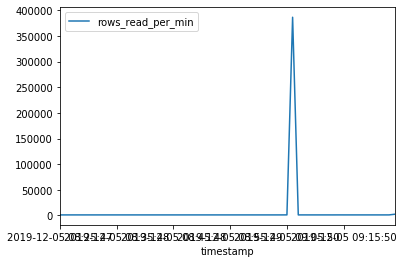

In [21]:
# Retrieve the number of rows read over the last day
# List the last 10 data points
# Graph the history
import matplotlib
import matplotlib.pyplot as plt

endTime = int(time.time())*1000
oneHour = 3600000
r = databaseAPI.getRowsRead((endTime-oneHour), endTime)
if (databaseAPI.getStatusCode(r)==200):
    json = databaseAPI.getJSON(r)
    if json['count'] > 0:
        df = pd.DataFrame(json_normalize(json['timeseries'])) #extract just the timeseries data
        print('Available Columns')
        print(', '.join(list(df)))
        df['timestamp'] = df['timestamp'].apply(epochtotimeseries)
        display(df[['timestamp','rows_read_per_min']].tail(20))
        df.plot.line(x='timestamp',y='rows_read_per_min') 
        plt.show()
    else: 
        print('No data returned')
else:
    print(databaseAPI.getStatusCode(r))

### Storage Usage
You can access the storage report page directly by calling it into an IFrame or you can access the data from an API. In the report below you can select the timeframe for storage usage, group by table or schema, select the object you want to analyze and then select View Details from the Actions column.

In [13]:
IFrame(database+'/console/?mode=compact#monitor/storage'+profileURL, width=1400, height=480)

You can also list storage by schema. The following example retrieves the current level of storage usage. 

In [14]:
# List storage used by schema
# Display the top ten schemas
r = databaseAPI.getTableStorageBySchema()
if (databaseAPI.getStatusCode(r)==200):
    json = databaseAPI.getJSON(r)        
    if json['count'] > 0: 
        df = pd.DataFrame(json_normalize(json['resources']))
        print(', '.join(list(df)))
        df['space_mb'] = df['data_physical_size_kb'].apply(lambda x: x / 1024)
        df = df.sort_values(by='data_physical_size_kb', ascending=False)    
        display(df[['tabschema','space_mb']].head(10))
    else: 
        print('No data returned') 
else:
    print("RC: "+str(databaseAPI.getStatusCode(r)))    

timestamp, tabschema, type, lastused, rowcompmode, data_logical_size_kb, index_logical_size_kb, long_logical_size_kb, lob_logical_size_kb, xml_logical_size_kb, column_organized_data_logical_size_kb, total_logical_size_kb, data_physical_size_kb, index_physical_size_kb, long_physical_size_kb, lob_physical_size_kb, xml_physical_size_kb, column_organized_data_physical_size_kb, total_physical_size_kb, estimated_reclaim_size_kb, est_adapt_svgs_kb, est_adapt_svgs_pct, est_static_svgs_kb, est_static_svgs_pct, est_reclaim_svgs_pct


,tabschema,space_mb
0,SYSIBM,14.09375
2,DB2INST1,12.25000
1,SYSTOOLS,5.18750


### Object Management
You can explore the objects in your database through the search objects API. This API requires an JSON payload to define the search criteria which can be complex. In this example we are looking for Views with "table" in their name. It will search through both user and catalog views. 

In [15]:
# Search for tables across all schemas that match simple search critera 
# Display the first 100
# Switch between searching tables or views
object = 'view'
#object = 'table'
r = databaseAPI.postSearchObjects(object,"TABLE",10,'true','false')
if (databaseAPI.getStatusCode(r)==200):
    json = databaseAPI.getJSON(r)
    df = pd.DataFrame(json_normalize(json))
    print('Columns:')
    print(', '.join(list(df)))
    display(df[[object+'_name']].head(100))
else:
    print("RC: "+str(databaseAPI.getStatusCode(r)))

Columns:
view_name, view_schema, owner, owner_type, read_only, valid, view_check, sql, create_time, alter_time, stats_time, optimize_query


,view_name
0,TABLES
1,EXTERNALTABLEOPTIONS
2,SQLTABLEPRIVILEGES
3,SQLTABLETYPES
4,SQLTABLES
5,EVENTTABLES
6,TABLES
7,TABLESPACES
8,ADMINTEMPTABLES
9,DBA_PART_TABLES


This example returns all the tables in a single schema. 

In [16]:
# Find all the tables in the SYSIBM schema and display the first 10
schema = 'SYSIBM'
r = databaseAPI.getTablesInSchema(schema)
if (databaseAPI.getStatusCode(r)==200):
    json = databaseAPI.getJSON(r)
    df = pd.DataFrame(json_normalize(json['resources']))
    print(', '.join(list(df)))
    display(df[['schema','name']].head(10))
else:
    print(databaseAPI.getStatusCode(r))   

schema, name


,schema,name
0,SYSIBM,SYSATTRIBUTES
1,SYSIBM,SYSAUDITEXCEPTIONS
2,SYSIBM,SYSAUDITPOLICIES
3,SYSIBM,SYSAUDITUSE
4,SYSIBM,SYSBUFFERPOOLNODES
5,SYSIBM,SYSBUFFERPOOLS
6,SYSIBM,SYSCHECKS
7,SYSIBM,SYSCODEPROPERTIES
8,SYSIBM,SYSCOLAUTH
9,SYSIBM,SYSCOLCHECKS


In [ ]:
IFrame(database+'/console/?mode=compact#monitor/inflight_executions'+profileURL, width=1400, height=360)

In [ ]:
# Retrieve the current statements running now
# Display the top 10 by execution time
r = databaseAPI.getInflightCurrentList()
if (databaseAPI.getStatusCode(r)==200):
    json = databaseAPI.getJSON(r)
    if json['count'] > 0:
        df = pd.DataFrame(json_normalize(json['resources']))
        print('Columns')
        print(', '.join(list(df)))
        df = df.sort_values(by='exec_time_ms', ascending=False)
        display(df[['application_name','stmt_text','exec_time_ms','estimated_runtime_ms']].head(10))
    else:
        print('No data returned')
else:
    code = databaseAPI.getStatusCode(r)
    databaseAPI.printResponse(r, code)

In [ ]:
IFrame(database+'/console/?mode=compact#monitor/connections'+profileURL, width=1400, height=480)

In [ ]:
# Display the 10 most recently started Database Connections
r = databaseAPI.getCurrentApplicationsConnections()
if (databaseAPI.getStatusCode(r)==200):
    json = databaseAPI.getJSON(r)
    if json['count'] > 0: 
        df = pd.DataFrame(json_normalize(json['resources']))
        print(', '.join(list(df)))
        df = df.sort_values(by='connection_start_time', ascending=False)
        df['connection_start_time'] = df['connection_start_time'].apply(epochtotimeseries)
        display(df[['application_name','application_handle','connection_start_time']].head(10))
    else: 
        print('No data returned')  
else:
    print(databaseAPI.getStatusCode(r))

### Managing Your History Database
If you are connected to the database you use to collect historical data you can determine how much storage is being used with the following cell. 

In [17]:
# Connect to the Db2 Data Management Console service
Console  = 'http://localhost:11080'
profile  = 'HISTORY'
user     = 'DB2INST1'
password = 'db2inst1'

# Set up the required connection
profileURL = "?profile="+profile
databaseAPI = Db2(Console+'/dbapi/v4')
databaseAPI.authenticate(user, password, profile)
database = Console

Retrieve the storage size for the Historical Data Repostory stored in IBMCONSOLE schema. If this doesn't run against the repository database you will get a zero result set.

Columns
timestamp, tabschema, data_logical_size_kb, index_logical_size_kb, long_logical_size_kb, lob_logical_size_kb, xml_logical_size_kb, column_organized_data_logical_size_kb, total_logical_size_kb, data_physical_size_kb, index_physical_size_kb, long_physical_size_kb, lob_physical_size_kb, xml_physical_size_kb, column_organized_data_physical_size_kb, total_physical_size_kb, estimated_reclaim_size_kb


,timestamp,total_physical_size_gb
5,2019-11-26 18:07:40,0.256836
6,2019-11-27 13:02:29,0.277344
7,2019-11-27 13:07:22,0.278320
8,2019-11-28 13:09:04,0.300781
9,2019-11-29 13:12:06,0.343750
10,2019-11-30 13:11:38,0.354492
11,2019-12-01 13:12:07,0.401367
12,2019-12-02 13:13:02,0.449219
13,2019-12-03 13:13:32,0.499023
14,2019-12-04 13:14:26,0.533203


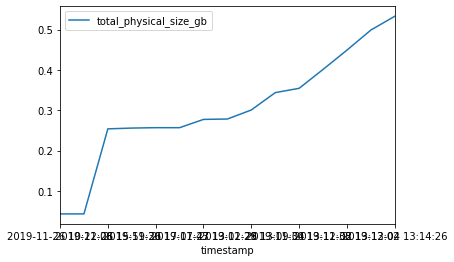

In [18]:
# List the last 10 data points
# Graph the history of the storage usage
tabSchema = 'IBMCONSOLE'
OneWeekStartTime = endTime - oneWeek
r = databaseAPI.getSchemaSize(0, endTime, tabSchema)
if (databaseAPI.getStatusCode(r)==200):
    json = databaseAPI.getJSON(r)
    if json['count'] > 0: 
        df = pd.DataFrame(json_normalize(json['timeseries']))
        print('Columns')
        print(', '.join(list(df)))
        df['total_physical_size_gb'] = df['total_physical_size_kb'].apply(KBtoGB)
        df['timestamp'] = df['timestamp'].apply(epochtotimeseries)
        display(df[['timestamp','total_physical_size_gb']].tail(10))
        df.plot(x='timestamp',y='total_physical_size_gb')
    else: 
        print('No data returned') 
else:
    print(databaseAPI.getStatusCode(r))

#### Credits: IBM 2019, Peter Kohlmann [kohlmann@ca.ibm.com]